In [ ]:
run_project = input("Czy chcesz uruchomić projekt? (tak/nie): ").lower()

if run_project != 'tak':
    raise SystemExit("Projekt nie zostanie uruchomiony.")
print("Projekt uruchomiony.")

## Biblioteka

In [ ]:
!pip install feature_engine
from pathlib import Path
import os
import re
from collections import OrderedDict
from feature_engine.outliers import Winsorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import loguniform, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    KBinsDiscretizer,
    OneHotEncoder,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_validate,
    StratifiedShuffleSplit,
)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from IPython.display import display
import joblib
import kagglehub
import pathlib
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

## EDA

Załadowano 100000 wierszy i 9 kolumn.



,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB

Statystyki opisowe:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,100000,3,Female,58552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100000.0,NaN,NaN,NaN,41.885856,22.51684,0.08,24.0,43.0,60.0,80.0
hypertension,100000.0,NaN,NaN,NaN,0.07485,0.26315,0.0,0.0,0.0,0.0,1.0
heart_disease,100000.0,NaN,NaN,NaN,0.03942,0.194593,0.0,0.0,0.0,0.0,1.0
smoking_history,100000,6,No Info,35816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,100000.0,NaN,NaN,NaN,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,NaN,NaN,NaN,5.527507,1.070672,3.5,4.8,5.8,6.2,9.0
blood_glucose_level,100000.0,NaN,NaN,NaN,138.05806,40.708136,80.0,100.0,140.0,159.0,300.0
diabetes,100000.0,NaN,NaN,NaN,0.085,0.278883,0.0,0.0,0.0,0.0,1.0



Rozkład klas:


,count
diabetes,
Brak cukrzycy,91500
Cukrzyca,8500


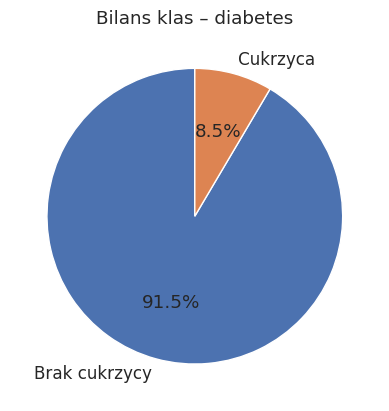


Braki danych w kolumnach:


,Liczba braków
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


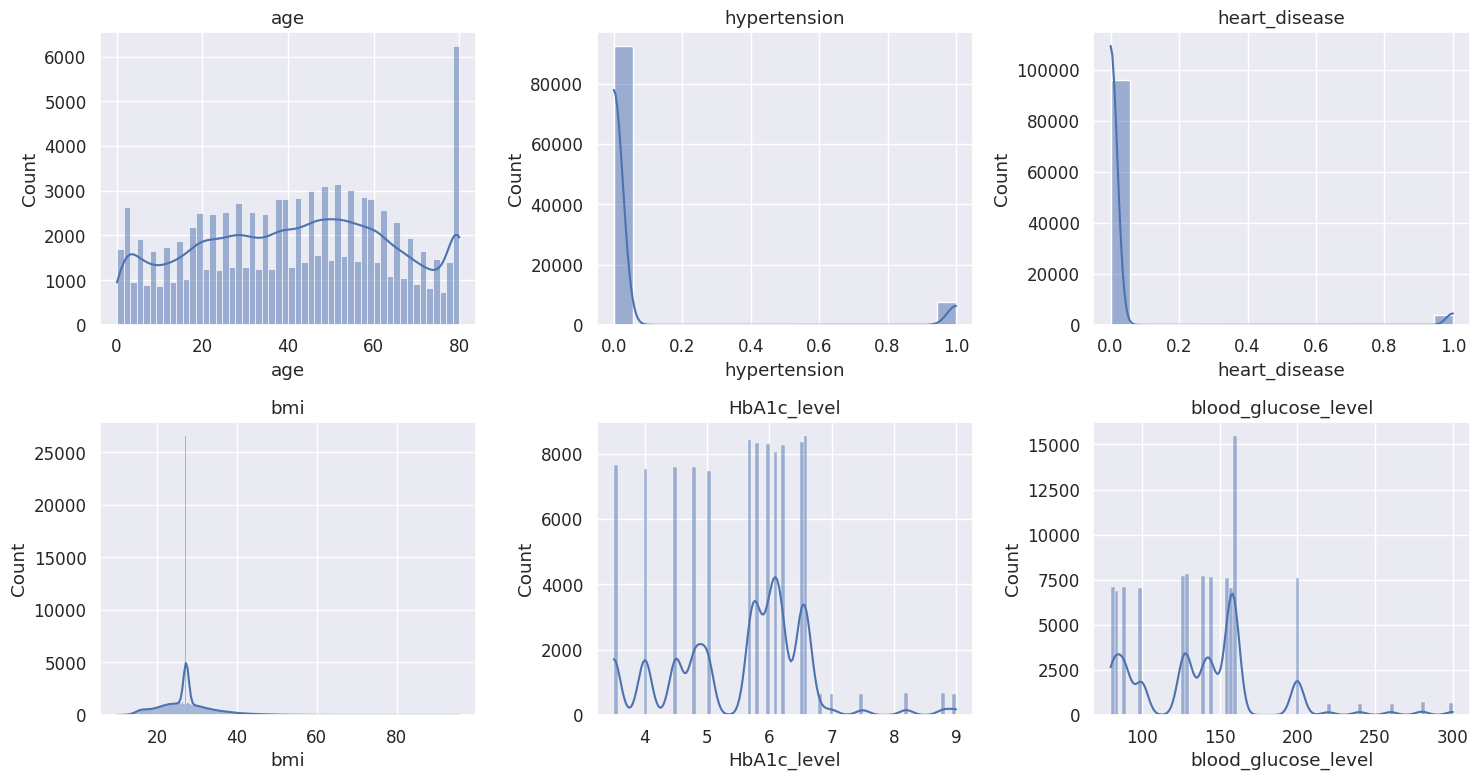

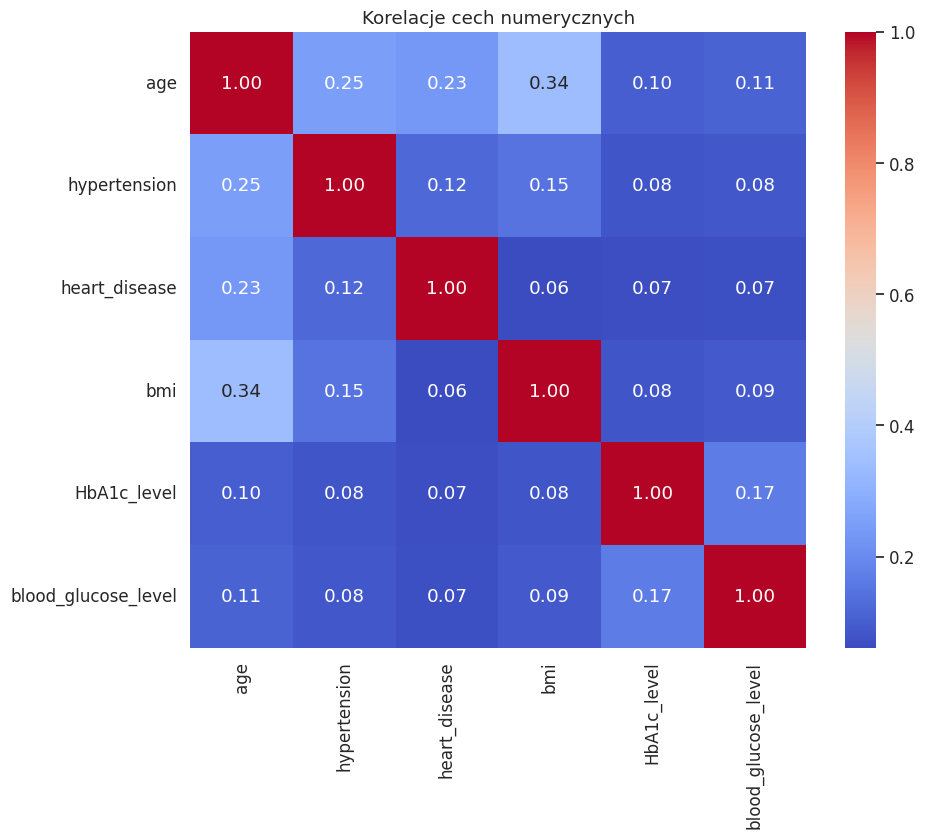

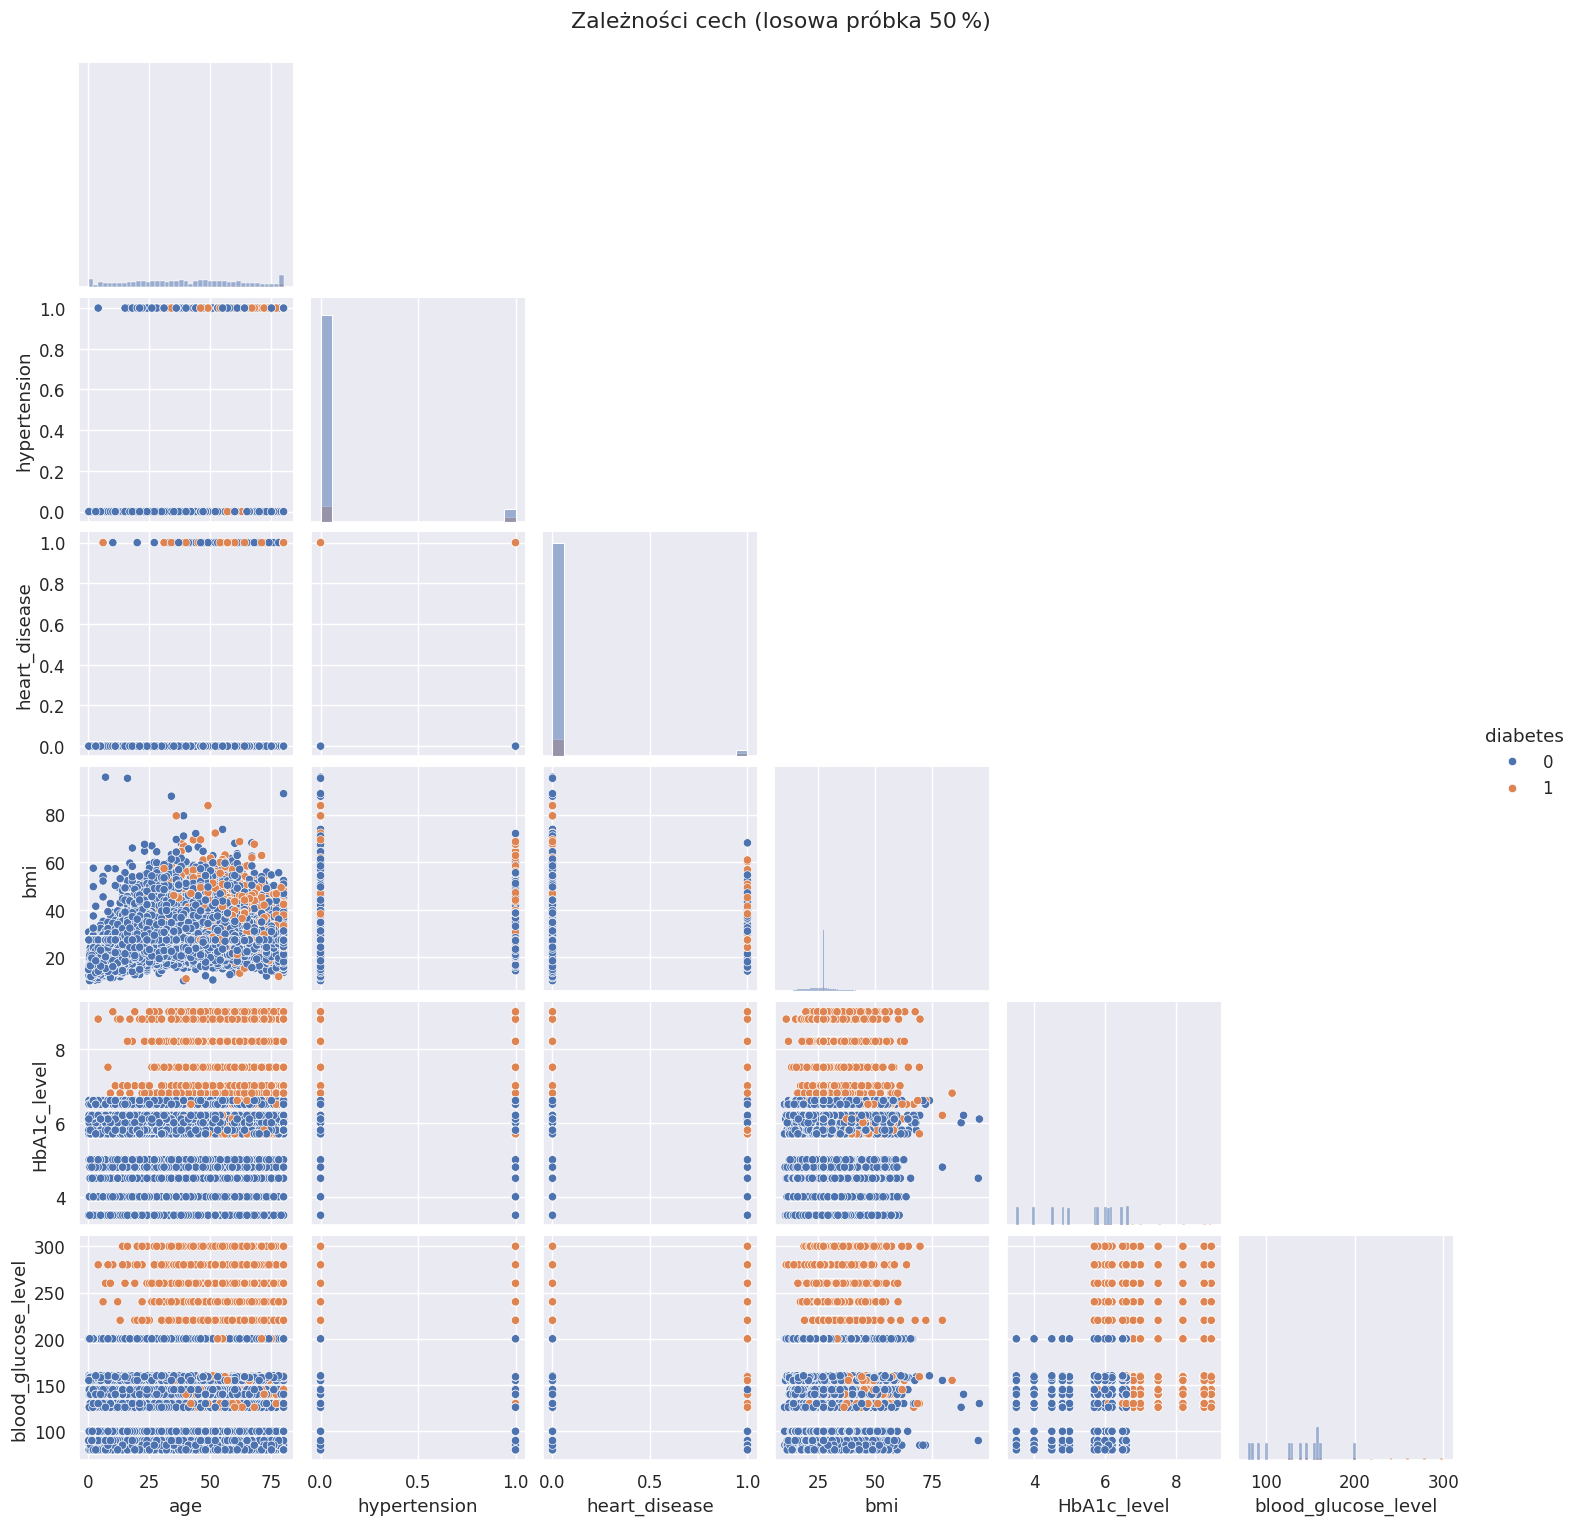

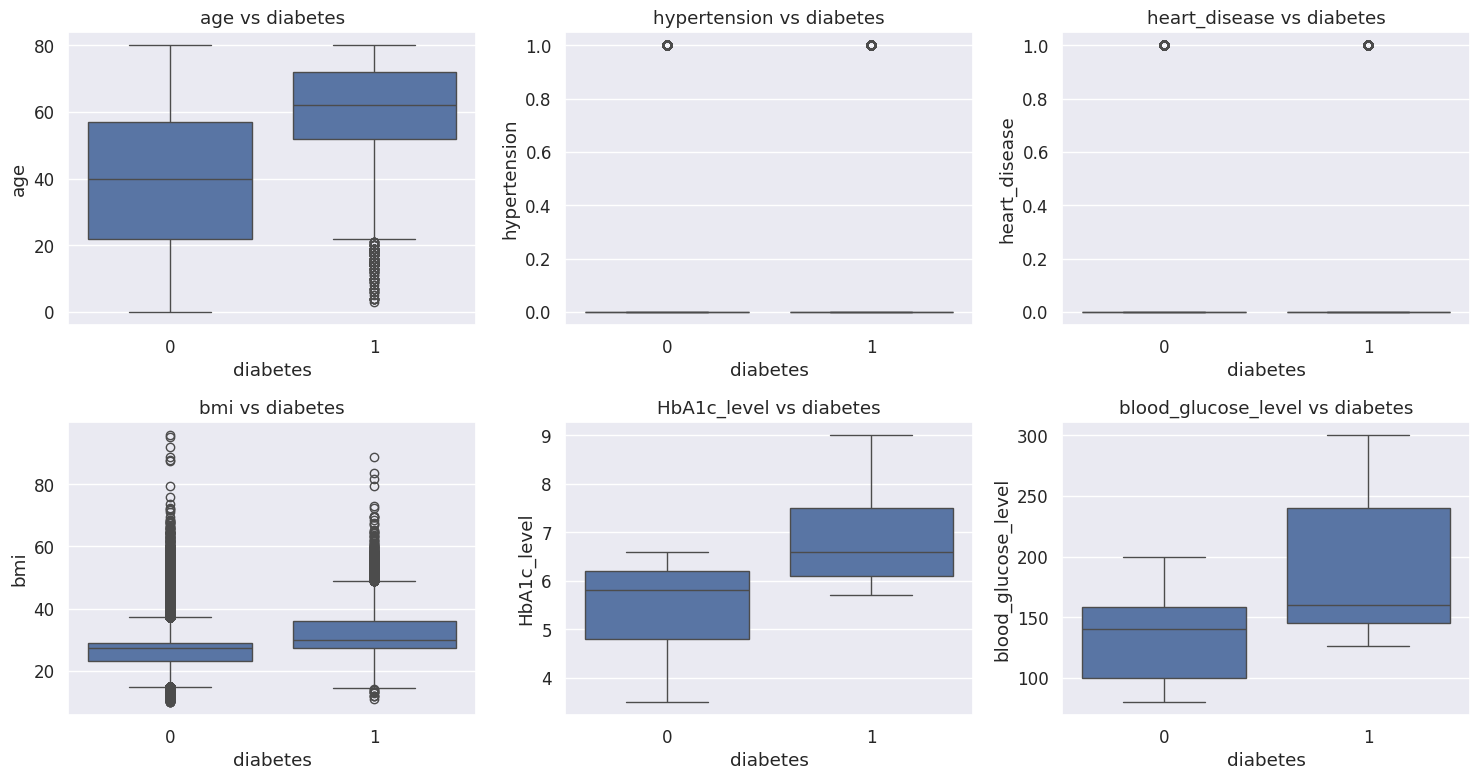

In [ ]:
plt.style.use("default")  # ustawienie stylu
sns.set(font_scale=1.1)  # skalowanie czcionki
pd.set_option("display.max_columns", None)  # pełny widok kolumn

path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")  # pobranie danych
path = pathlib.Path(path)  # konwersja ścieżki
csv_file = next(path.glob("*.csv"))  # wyszukanie pliku CSV
df = pd.read_csv(csv_file.as_posix())  # wczytanie danych

if df["diabetes"].dtype == object:  # detekcja typu etykiety
    df["diabetes"] = (  # konwersja etykiet
        df["diabetes"]
        .str.strip()  # usunięcie spacji
        .str.lower()  # zmiana liter na małe
        .map({"positive": 1, "yes": 1, "negitive": 0, "negative": 0, "no": 0})  # mapowanie wartości
        .astype(int)  # typ liczbowy
    )

target = "diabetes"  # zmienna celu
feature_cols = df.columns.drop(target)  # wybór cech

print(f"Załadowano {df.shape[0]} wierszy i {df.shape[1]} kolumn.\n")  # podsumowanie danych
display(df.head())  # podgląd danych
df.info()  # struktura DataFrame

print("\nStatystyki opisowe:")  # nagłówek statystyk
display(df.describe(include="all").T)  # statystyki opisowe

class_counts = df[target].value_counts().rename(index={0: "Brak cukrzycy", 1: "Cukrzyca"})  # zliczenie klas
print("\nRozkład klas:")  # nagłówek rozkładu
display(class_counts)  # wyświetlenie rozkładu

fig, ax = plt.subplots()  # inicjalizacja wykresu
ax.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)  # wykres kołowy
ax.set_title(f"Bilans klas – {target}")  # tytuł wykresu
plt.show()  # wyświetlenie

missing_summary = df.isna().sum().to_frame("Liczba braków")  # podsumowanie braków
print("\nBraki danych w kolumnach:")  # nagłówek braków
display(missing_summary)  # wyświetlenie braków

num_cols = df[feature_cols].select_dtypes(include="number").columns  # cechy numeryczne
n = len(num_cols)  # liczba cech
cols = 3  # kolumny wykresów
rows = (n + cols - 1) // cols  # wiersze wykresów
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))  # siatka wykresów
axes = axes.flatten()  # spłaszczenie osi
for ax, col in zip(axes, num_cols):  # iteracja po cechach
    sns.histplot(df[col], kde=True, ax=ax)  # histogram z KDE
    ax.set_title(col)  # tytuł wykresu
for ax in axes[len(num_cols):]:  # pozostałe puste osie
    ax.axis("off")  # wyłączenie osi
plt.tight_layout()  # układ wykresów
plt.show()  # wyświetlenie

corr = df[num_cols].corr()  # macierz korelacji
plt.figure(figsize=(10, 8))  # rozmiar mapy
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)  # mapa cieplna
plt.title("Korelacje cech numerycznych")  # tytuł mapy
plt.show()  # wyświetlenie mapy

sns.pairplot(df.sample(frac=0.5, random_state=42), hue=target,
             vars=num_cols, diag_kind="hist", corner=True)  # analiza par cech
plt.suptitle("Zależności cech (losowa próbka 50 %)", y=1.02)  # tytuł zbiorczy
plt.show()  # wyświetlenie pairplot

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))  # siatka wykresów pudełkowych
axes = axes.flatten()  # spłaszczenie osi
for ax, col in zip(axes, num_cols):  # iteracja po cechach
    sns.boxplot(x=target, y=col, data=df, ax=ax)  # wykres pudełkowy
    ax.set_title(f"{col} vs {target}")  # tytuł wykresu
for ax in axes[len(num_cols):]:  # pozostałe puste osie
    ax.axis("off")  # wyłączenie osi
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresów pudełkowych


## Preprocessing

In [ ]:
target = "diabetes"  # zmienna celu
feature_cols = df.columns.drop(target)  # cechy

X = df[feature_cols].copy()  # dane wejściowe
y = df[target].copy()  # etykiety

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,  # proporcja testu
    stratify=y,  # proporcja klas
    random_state=42  # ziarno losowości
)

class Winsorizer(BaseEstimator, TransformerMixin):  # klasa przycinająca
    def __init__(self, lower_q=0.01, upper_q=0.99):  # kwantyle
        self.lower_q = lower_q
        self.upper_q = upper_q
    def fit(self, X, y=None):  # dopasowanie
        arr = X if isinstance(X, np.ndarray) else X.to_numpy()  # konwersja
        q_low  = np.nanquantile(arr, self.lower_q, axis=0)  # dolny kwantyl
        q_high = np.nanquantile(arr, self.upper_q, axis=0)  # górny kwantyl
        self.bounds_ = np.vstack([q_low, q_high]).T  # progi
        return self
    def transform(self, X):  # transformacja
        arr = X if isinstance(X, np.ndarray) else X.to_numpy()  # konwersja
        for i in range(arr.shape[1]):  # iteracja
            lo, hi = self.bounds_[i]  # zakres
            arr[:, i] = np.clip(arr[:, i], lo, hi)  # przycięcie
        return arr
    def get_feature_names_out(self, input_features=None):  # nazwy cech
        return np.asarray(
            input_features
            if input_features is not None
            else self.feature_names_in_,
            dtype=object,
        )

numeric_cols     = df[feature_cols].select_dtypes(include="number").columns.tolist()  # cechy numeryczne
categorical_cols = df[feature_cols].select_dtypes(exclude="number").columns.tolist()  # cechy kategoryczne

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # imputacja medianą
    ("winsor",  Winsorizer(0.01, 0.99)),  # winsoryzacja
    ("scaler",  StandardScaler()),  # skalowanie
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # imputacja najczęstsza
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # kodowanie
])

preprocess_ct = ColumnTransformer([
    ("num", num_pipe, numeric_cols),  # przetwarzanie numerycznych
    ("cat", cat_pipe, categorical_cols),  # przetwarzanie kategorycznych
], remainder="drop")  # pozostałe odrzucenie

prep_pipeline = ImbPipeline([
    ("preprocess",  preprocess_ct),  # etap preprocessingu
    ("undersample", RandomUnderSampler(random_state=42)),  # undersampling
])

X_train_proc, y_train_bal = prep_pipeline.fit_resample(X_train, y_train)  # dopasowanie i balans
X_test_proc  = prep_pipeline.named_steps["preprocess"].transform(X_test)  # transformacja testu

print(f"Po preprocessingu: X_train={X_train_proc.shape}, X_test={X_test_proc.shape}")  # rozmiary
print("Rozkład klas po undersamplingu w train:", np.bincount(y_train_bal))  # rozkład klas


Po preprocessingu: X_train=(13600, 15), X_test=(20000, 15)
Rozkład klas po undersamplingu w train: [6800 6800]


## EDA po preprocessingu

Przetworzone kolumny: 15


,num__age,num__hypertension,num__heart_disease,num__bmi,num__HbA1c_level,num__blood_glucose_level,cat__gender_Female,cat__gender_Male,cat__gender_Other,cat__smoking_history_No Info,cat__smoking_history_current,cat__smoking_history_ever,cat__smoking_history_former,cat__smoking_history_never,cat__smoking_history_not current
0,-1.283419,-0.284414,-0.202792,0.007358,0.631660,-1.318461,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.883806,-0.284414,-0.202792,0.007358,-1.430891,1.545349,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.350990,-0.284414,-0.202792,1.002120,0.256650,0.524338,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.839405,-0.284414,-0.202792,1.330580,0.912916,0.524338,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.403833,-0.284414,-0.202792,0.046460,0.256650,-0.297451,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0



Statystyki opisowe:


,count,mean,std,min,25%,50%,75%,max
num__age,13600.0,0.381734,0.952667,-1.816235,-0.262187,0.537037,1.114255,1.691473
num__hypertension,13600.0,0.282296,1.353775,-0.284414,-0.284414,-0.284414,-0.284414,3.516004
num__heart_disease,13600.0,0.260020,1.470382,-0.202792,-0.202792,-0.202792,-0.202792,4.931172
num__bmi,13600.0,0.311938,1.096466,-1.985295,-0.249153,0.007358,0.861743,3.370155
num__HbA1c_level,13600.0,0.593649,1.186947,-1.899652,0.162898,0.537907,1.006669,3.069219
num__blood_glucose_level,13600.0,0.620294,1.365956,-1.442975,-0.197840,0.424728,1.545349,3.537565
cat__gender_Female,13600.0,0.560074,0.496396,0.000000,0.000000,1.000000,1.000000,1.000000
cat__gender_Male,13600.0,0.439706,0.496370,0.000000,0.000000,0.000000,1.000000,1.000000
cat__gender_Other,13600.0,0.000221,0.014851,0.000000,0.000000,0.000000,0.000000,1.000000
cat__smoking_history_No Info,13600.0,0.274265,0.446159,0.000000,0.000000,0.000000,1.000000,1.000000


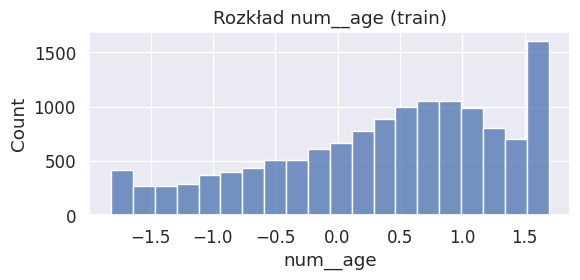

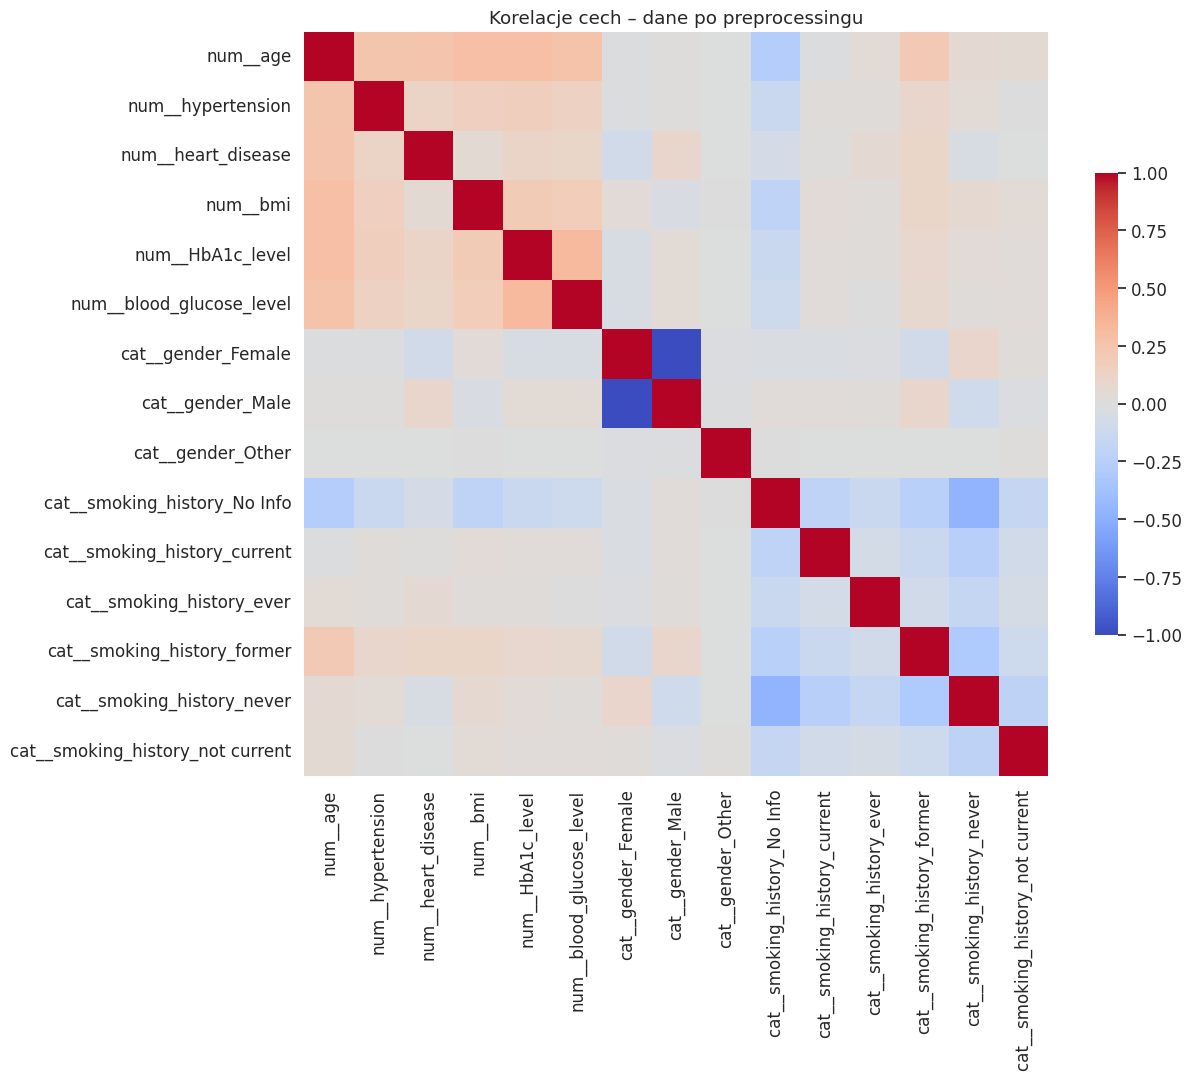

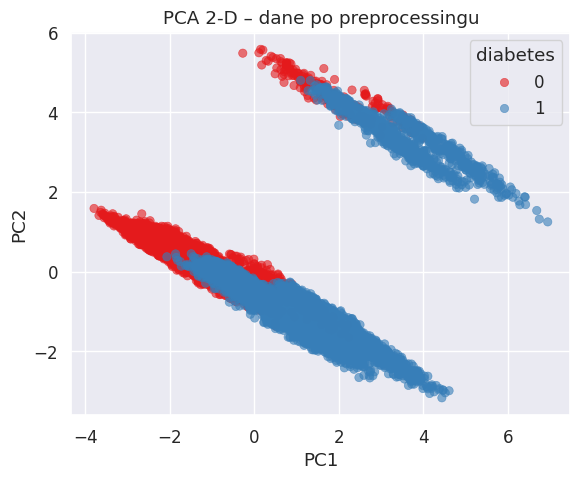

Bilans klas w zbiorze train po preprocessingu:


,count
diabetes,
Brak cukrzycy,6800
Cukrzyca,6800


In [ ]:
ct = prep_pipeline.named_steps["preprocess"]  # pobranie preprocessingu
proc_cols = ct.get_feature_names_out()  # pobranie nazw cech
X_train_df = pd.DataFrame(X_train_proc, columns=proc_cols)  # utworzenie DataFrame

print("Przetworzone kolumny:", len(proc_cols))  # liczba kolumn
display(X_train_df.head())  # podgląd danych
print("\nStatystyki opisowe:")  # nagłówek statystyk
display(X_train_df.describe().T)  # statystyki opisowe

plt.figure(figsize=(6, 3))  # inicjalizacja wykresu
sns.histplot(X_train_df[proc_cols[0]], bins=20, kde=False)  # histogram
plt.title(f"Rozkład {proc_cols[0]} (train)")  # tytuł wykresu
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

corr_proc = X_train_df.corr()  # macierz korelacji
plt.figure(figsize=(12, 10))  # rozmiar mapy
sns.heatmap(corr_proc, cmap="coolwarm", center=0, square=True,  # mapa cieplna
            cbar_kws={"shrink": .6}, vmax=1, vmin=-1)
plt.title("Korelacje cech – dane po preprocessingu")  # tytuł mapy
plt.show()  # wyświetlenie mapy

from sklearn.decomposition import PCA  # import PCA
pca = PCA(n_components=2, random_state=42)  # inicjalizacja PCA
proj = pca.fit_transform(X_train_df)  # projekcja danych
plt.figure(figsize=(6, 5))  # inicjalizacja wykresu PCA
sns.scatterplot(x=proj[:, 0], y=proj[:, 1],  # wykres punktowy
                hue=pd.Series(y_train_bal).reset_index(drop=True),
                palette="Set1", alpha=.6, edgecolor=None)
plt.title("PCA 2-D – dane po preprocessingu")  # tytuł wykresu
plt.xlabel("PC1"); plt.ylabel("PC2")  # etykiety osi
plt.legend(title="diabetes")  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

print("Bilans klas w zbiorze train po preprocessingu:")  # nagłówek bilansu
display(pd.Series(y_train_bal).value_counts()
        .rename(index={0: "Brak cukrzycy", 1: "Cukrzyca"}))  # wyświetlenie rozkładu klas


## Hiperparametry+ Trening

In [ ]:
models_dir = Path(os.getcwd()) / "models"  # katalog modeli
models_dir.mkdir(parents=True, exist_ok=True)  # utworzenie katalogu

def tune_on_sample_then_refit(estimator, param_dist, n_iter, X_full, y_full,
                              sample_frac=0.01, tag="model"):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=1-sample_frac, random_state=42)  # podział losowy z zachowaniem proporcji
    idx_sample, _ = next(sss.split(X_full, y_full))  # indeksy próbki
    X_sample, y_sample = X_full[idx_sample], y_full[idx_sample]  # pobranie próbki

    cv_search = RandomizedSearchCV(
        estimator, param_dist, n_iter=n_iter,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # walidacja krzyżowa
        scoring="roc_auc", n_jobs=-1, random_state=42  # metryka AUC
    )
    cv_search.fit(X_sample, y_sample)  # strojenie na próbce

    best = cv_search.best_estimator_  # wybór najlepszego estymatora
    best.fit(X_full, y_full)  # dopasowanie do pełnych danych
    joblib.dump(best, models_dir / f"{tag}.joblib")  # zapis modelu
    print(f"{tag} – najlepsze parametry:", cv_search.best_params_)  # wyświetlenie parametrów
    return best  # zwrócenie najlepszego modelu

X_full = np.asarray(X_train_proc)  # pełne cechy treningowe
y_full = np.asarray(y_train_bal)  # pełne etykiety treningowe

tune_on_sample_then_refit(
    LogisticRegression(solver="liblinear", random_state=42),  # inicjalizacja prostego LR
    {"C": loguniform(1e-3, 1e3)},  # zasięg regularyzacji
    n_iter=20,  # liczba prób
    X_full=X_full, y_full=y_full,  # pełne dane
    tag="logreg_simple"  # nazwa modelu
)

tune_on_sample_then_refit(
    LogisticRegression(solver="saga", max_iter=10000, random_state=42),  # inicjalizacja średniego LR
    {"penalty": ["l1", "l2"],  # typy kar
     "C": loguniform(1e-3, 1e3),  # zasięg regularyzacji
     "class_weight": [None, "balanced"]},  # wagi klas
    n_iter=40,  # liczba prób
    X_full=X_full, y_full=y_full,  # pełne dane
    tag="logreg_mid"  # nazwa modelu
)

tune_on_sample_then_refit(
    LogisticRegression(solver="saga", penalty="elasticnet",
                       max_iter=10000, random_state=42),  # inicjalizacja zaawansowanego LR
    {"C": loguniform(1e-3, 1e3),  # zasięg regularyzacji
     "l1_ratio": uniform(0, 1),  # stosunek L1
     "class_weight": [None, "balanced"]},  # wagi klas
    n_iter=40,  # liczba prób
    X_full=X_full, y_full=y_full,  # pełne dane
    tag="logreg_advanced"  # nazwa modelu
)


logreg_simple – najlepsze parametry: {'C': np.float64(0.3905441275210791)}
logreg_mid – najlepsze parametry: {'C': np.float64(0.5450293694558254), 'class_weight': None, 'penalty': 'l2'}
logreg_advanced – najlepsze parametry: {'C': np.float64(1.3335385049873036), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.32533033076326434)}


LogisticRegression(C=np.float64(1.3335385049873036), class_weight='balanced',
                   l1_ratio=np.float64(0.32533033076326434), max_iter=10000,
                   penalty='elasticnet', random_state=42, solver='saga')

## Ewaluacja

,CV_ROC_AUC,CV_Accuracy,CV_BalAcc,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_BalAcc,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_PR_AUC,Test_MCC
Model,,,,,,,,,,,,,,
Simple,0.963,0.884,0.884,0.887,0.881,0.884,0.887,0.89,0.423,0.894,0.574,0.963,0.82,0.567
Mid,0.963,0.884,0.884,0.887,0.881,0.884,0.888,0.89,0.424,0.894,0.575,0.963,0.82,0.568
Advanced,0.963,0.884,0.884,0.887,0.881,0.884,0.888,0.89,0.424,0.894,0.575,0.963,0.82,0.567


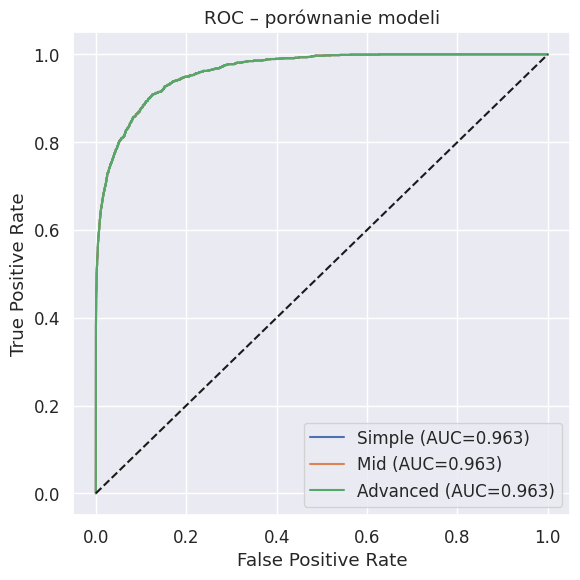

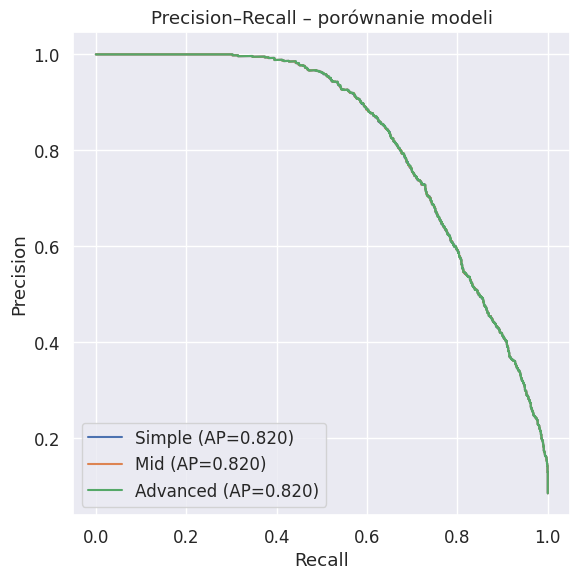

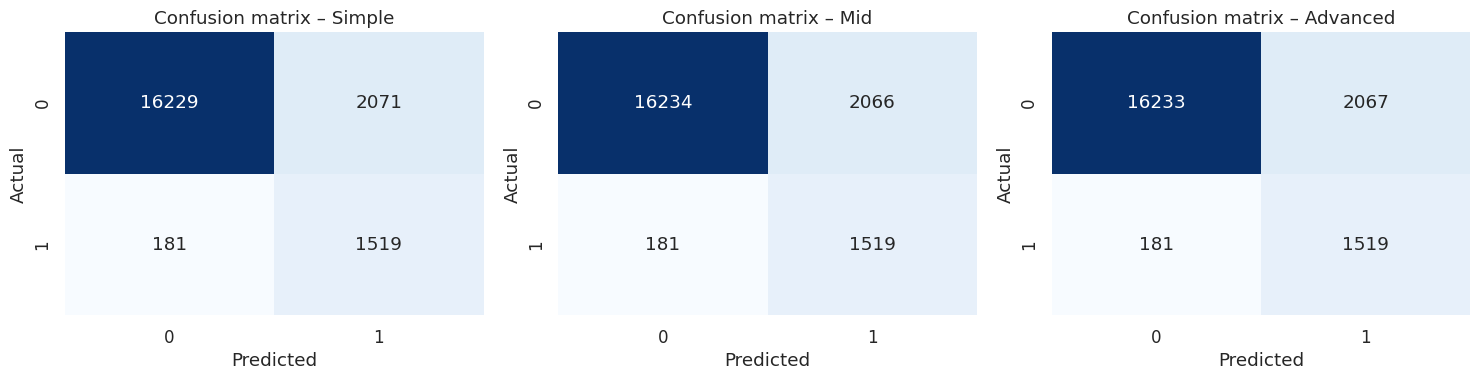

In [ ]:
models_dir = Path(os.getcwd()) / "models"  # katalog na modele
models = {
    "Simple":   joblib.load(models_dir / "logreg_simple.joblib"),   # ładowanie prostego modelu
    "Mid":      joblib.load(models_dir / "logreg_mid.joblib"),      # ładowanie średniego modelu
    "Advanced": joblib.load(models_dir / "logreg_advanced.joblib"), # ładowanie zaawansowanego modelu
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # konfiguracja StratifiedKFold
y_train = y_train_bal  # alias etykiet treningowych

records, curves = [], {}  # inicjalizacja zbiorów wyników

for tag, model in models.items():  # iteracja po modelach
    cv_res = cross_validate(  # walidacja krzyżowa metryk
        model,
        X_train_proc,
        y_train,
        cv=cv,
        scoring={  # słownik metryk do CV
            "ROC_AUC": "roc_auc",
            "Accuracy": "accuracy",
            "BalAcc": "balanced_accuracy",
            "Precision": "precision",
            "Recall": "recall",
            "F1": "f1",
        },
        n_jobs=-1,
        return_train_score=False
    )

    y_proba = model.predict_proba(X_test_proc)[:, 1]  # prawdopodobieństwa klasy pozytywnej
    y_pred  = model.predict(X_test_proc)  # predykcje klas

    records.append({  # agregacja metryk do słownika
        "Model":          tag,
        "CV_ROC_AUC":     cv_res["test_ROC_AUC"].mean(),       # średnia AUC z CV
        "CV_Accuracy":    cv_res["test_Accuracy"].mean(),      # średnia Accuracy z CV
        "CV_BalAcc":      cv_res["test_BalAcc"].mean(),        # średnia BalAcc z CV
        "CV_Precision":   cv_res["test_Precision"].mean(),     # średnia Precision z CV
        "CV_Recall":      cv_res["test_Recall"].mean(),        # średnia Recall z CV
        "CV_F1":          cv_res["test_F1"].mean(),            # średnia F1 z CV
        "Test_Accuracy":  accuracy_score(y_test, y_pred),      # Accuracy na teście
        "Test_BalAcc":    balanced_accuracy_score(y_test, y_pred),  # BalAcc na teście
        "Test_Precision": precision_score(y_test, y_pred, zero_division=0),  # Precision na teście
        "Test_Recall":    recall_score(y_test, y_pred, zero_division=0),     # Recall na teście
        "Test_F1":        f1_score(y_test, y_pred, zero_division=0),         # F1 na teście
        "Test_ROC_AUC":   roc_auc_score(y_test, y_proba),    # AUC ROC na teście
        "Test_PR_AUC":    average_precision_score(y_test, y_proba),  # AUC PR na teście
        "Test_MCC":       matthews_corrcoef(y_test, y_pred),  # współczynnik MCC
    })

    fpr, tpr, _   = roc_curve(y_test, y_proba)  # krzywa ROC
    prec, rec_, _ = precision_recall_curve(y_test, y_proba)  # krzywa Precision–Recall
    curves[tag]   = {"fpr": fpr, "tpr": tpr, "prec": prec, "rec": rec_}  # zapis krzywych

metrics_df = pd.DataFrame(records).set_index("Model").round(3)  # tworzenie DataFrame metryk
display(metrics_df)  # wyświetlenie tabeli metryk

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu ROC
for tag, pts in curves.items():  # iteracja po krzywych ROC
    auc = metrics_df.loc[tag, "Test_ROC_AUC"]  # pobranie wartości AUC
    plt.plot(pts["fpr"], pts["tpr"], label=f"{tag} (AUC={auc:.3f})")  # rysowanie krzywej
plt.plot([0, 1], [0, 1], "k--")  # linia losowa
plt.xlabel("False Positive Rate")  # etykieta osi X
plt.ylabel("True Positive Rate")  # etykieta osi Y
plt.title("ROC – porównanie modeli")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu Precision–Recall
for tag, pts in curves.items():  # iteracja po krzywych PR
    ap = metrics_df.loc[tag, "Test_PR_AUC"]  # pobranie wartości AP
    plt.plot(pts["rec"], pts["prec"], label=f"{tag} (AP={ap:.3f})")  # rysowanie krzywej
plt.xlabel("Recall")  # etykieta osi X
plt.ylabel("Precision")  # etykieta osi Y
plt.title("Precision–Recall – porównanie modeli")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))  # inicjalizacja siatki macierzy pomyłek
for ax, (tag, model) in zip(axes, models.items()):  # iteracja po modelach
    cm = confusion_matrix(y_test, model.predict(X_test_proc))  # obliczenie macierzy pomyłek
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)  # rysowanie macierzy
    ax.set_title(f"Confusion matrix – {tag}")  # tytuł pod wykresem
    ax.set_xlabel("Predicted")  # etykieta osi X
    ax.set_ylabel("Actual")  # etykieta osi Y
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie macierzy pomyłek
